# University of York: APPLIED ARTIFICIAL INTELLIGENCE
## Summative assignment

### **Source file 3**: Machine learning model (Long short term memory) and SHAP values

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking


In [ ]:
# Import data with year range found from AI search
df = pd.read_csv("Final_combined_dataset.csv")
df = df[df['Year'].isin(range(1952,2022))]
df.rename(
    columns={
       'Countries, territories and areas': "country",
       'Year': 'year',
       'region_' : 'region',
       'Under-five mortality rate (per 1000 live births) (SDG 3.2.1)_ Both sexes': 'mortality_rate_both_sexes',
       'Under-five mortality rate (per 1000 live births) (SDG 3.2.1)_ Male': 'mortality_rate_male',
       'Under-five mortality rate (per 1000 live births) (SDG 3.2.1)_ Female': 'mortality_rate_female',
       'Number of deaths among children under-five_ Both sexes': 'num_deaths_under_5_both_sexes',
       'Number of deaths among children under-five_ Male': 'num_deaths_under_5_male',
       'Number of deaths among children under-five_ Female': 'num_deaths_under_5_female', 
       'Early initiation of breastfeeding (%)': 'early_breastfeeding_percent',
       'Infants exclusively breastfed for the first six months of life (%)': 'infants_excl_breastfeeding_percent'
    }, inplace=True
)
# Select relevant columns. Set index to year.
df = df[[
    'country',
    'year',
    'mortality_rate_both_sexes',
    'early_breastfeeding_percent',
    'infants_excl_breastfeeding_percent',
]].sort_values(['year'], ascending=True)

num_cols = ['mortality_rate_both_sexes','early_breastfeeding_percent','infants_excl_breastfeeding_percent']


In [ ]:
def impute_num_cols(df, num_cols):
    for col in num_cols:
        df[f"{col}_missing"] = df[col].isnull().astype(int)
        df[f"{col}"] = df[col].fillna(0)
    return df

# Add lagged values to data
def add_lags_to_cols(df, num_lags, cols):
    for c in cols:
        for lag in range(1, num_lags+1):
            df[f"{c}_lag_{lag}"] = df[c].shift(lag)
    return df[num_lags:]

# One-Hot encode country
from sklearn.preprocessing import OneHotEncoder
def fit_encoder(df, encoder, fit=False):
    cat_df = df[['country']]
    if fit:
        encoder.fit(cat_df)
    labels = encoder.transform(cat_df)
    encoded_df = pd.DataFrame(labels, columns=encoder.get_feature_names_out(['country']))
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
    return df, encoder

# # Min-max scale
# def scale_col(df, scaler, col, fit=False):
#     data = df[[col]]
#     if fit:
#         scaler.fit(data)
#     scaled = scaler.transform(data)
#     df[col] = scaled
#     return df

# SVD
def dim_reduction(df, reducer, cols, fit=False):
    data = df[cols]
    if fit:
        reducer.fit(data)
    reduced = reducer.transform(data)
    reduced_df = pd.DataFrame(reduced, columns=['ohe_c_1', 'ohe_c_2'])
    df = pd.concat([df.reset_index(drop=True), reduced_df], axis=1).drop(
        columns=cols
    )
    return df


In [102]:
# Impute missing values, add masking columns
data = impute_num_cols(df, num_cols)
# Add lagged values by country
countries = data['country'].unique()
lag_df_by_country = {
    c: add_lags_to_cols(
        data[data['country'] == c],
        num_lags=10, # can be tuned
        cols=num_cols
    )
    for c in countries
}
data = pd.concat([v for v in lag_df_by_country.values()], axis=0).sort_values(by=['country', 'year']).reset_index(drop=True)
# Produce train test split
SPLIT_YEAR = 2010
train_df = data[data['year'] < SPLIT_YEAR]
test_df = data[data['year'] >= SPLIT_YEAR]
# Create encoder
encoder = OneHotEncoder(sparse_output=False)
# Fit encoder on train data and transform
train_df, encoder = fit_encoder(train_df, encoder, fit=True)
# Transform test data on pretrained encoder
test_df, _ = fit_encoder(test_df, encoder, fit=False)
# Perform dimensionality reduction on one-hot encodings
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
train_df = dim_reduction(train_df, svd, [c for c in train_df.columns if 'country_' in c], fit=True)
test_df = dim_reduction(test_df, svd, [c for c in test_df.columns if 'country_' in c], fit=False)

/var/folders/dl/4ftjqphn6jl0c7zhmph3khc00000gn/T/ipykernel_47462/4144943896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{c}_lag_{lag}"] = df[c].shift(lag)
/var/folders/dl/4ftjqphn6jl0c7zhmph3khc00000gn/T/ipykernel_47462/4144943896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{c}_lag_{lag}"] = df[c].shift(lag)
/var/folders/dl/4ftjqphn6jl0c7zhmph3khc00000gn/T/ipykernel_47462/4144943896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [46]:
# Build ML Model
look_back=1
#Create training set
X_train = train_df.drop(columns = ['mortality_rate_both_sexes', 'year', 'country'])
y_train = train_df['mortality_rate_both_sexes']
#Create testing set
X_test = test_df.drop(columns = ['mortality_rate_both_sexes', 'year', 'country'])
y_test = test_df['mortality_rate_both_sexes']

X_train

,early_breastfeeding_percent,infants_excl_breastfeeding_percent,mortality_rate_both_sexes_missing,early_breastfeeding_percent_missing,infants_excl_breastfeeding_percent_missing,mortality_rate_both_sexes_lag_1,mortality_rate_both_sexes_lag_2,mortality_rate_both_sexes_lag_3,mortality_rate_both_sexes_lag_4,mortality_rate_both_sexes_lag_5,...,infants_excl_breastfeeding_percent_lag_3,infants_excl_breastfeeding_percent_lag_4,infants_excl_breastfeeding_percent_lag_5,infants_excl_breastfeeding_percent_lag_6,infants_excl_breastfeeding_percent_lag_7,infants_excl_breastfeeding_percent_lag_8,infants_excl_breastfeeding_percent_lag_9,infants_excl_breastfeeding_percent_lag_10,ohe_c_1,ohe_c_2
0,0.0,0.0,0,0,0,323.94,329.42,334.85,340.16,345.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020458,-0.018441
1,0.0,0.0,0,0,0,318.37,323.94,329.42,334.85,340.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020458,-0.018441
2,0.0,0.0,0,0,0,312.83,318.37,323.94,329.42,334.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020458,-0.018441
3,0.0,0.0,0,0,0,307.24,312.83,318.37,323.94,329.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020458,-0.018441
4,0.0,0.0,0,0,0,301.85,307.24,312.83,318.37,323.94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020458,-0.018441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7764,0.0,0.0,0,0,0,26.89,27.73,28.57,29.43,30.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003038,0.000343
7765,0.0,24.8,0,0,0,26.06,26.89,27.73,28.57,29.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003038,0.000343
7766,0.0,0.0,0,0,0,25.24,26.06,26.89,27.73,28.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003038,0.000343
7767,0.0,0.0,0,0,0,24.42,25.24,26.06,26.89,27.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003038,0.000343


In [ ]:
# ProfitCreate and fit the LSTM
train_model = True
model = None
if train_model:
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(len(X_train.columns),1)))
    model.add(LSTM(32, input_shape=(1,look_back)))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile (loss = 'mean_squared_error',optimizer ='adam')
    model.fit(X_train ,y_train, epochs =50, batch_size =32, verbose=1)
else:
    model = tf.keras.models.load_model('my_model.keras')

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9858.8672
Epoch 2/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4481.9229
Epoch 3/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2067.8875
Epoch 4/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 964.4440
Epoch 5/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 538.0690
Epoch 6/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 271.4371
Epoch 7/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 206.8508
Epoch 8/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 119.6549
Epoch 9/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 129.6321
Epoch 10/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 70.8712
Epoch 11/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 82.2164
Epoch 12/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 76.1206
Epoch 13/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 61.6650
Epoch 14/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 44.4549
Epoch 15/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2

In [92]:
# Save model after training
model.save('my_model.keras')

In [93]:
from sklearn.metrics import mean_squared_error
#make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train,train_predict[:,0]))
train_score
test_score = np.sqrt(mean_squared_error(y_test,test_predict[:,0]))
train_score, test_score


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(5.42587814032922, 4.937140068991207)

In [57]:
# Add predictions to test set
test_df['mortality_rate_both_sexes_predicted'] = test_predict
test_df[test_df['country'] == 'Zimbabwe']


,country,year,mortality_rate_both_sexes,early_breastfeeding_percent,infants_excl_breastfeeding_percent,mortality_rate_both_sexes_missing,early_breastfeeding_percent_missing,infants_excl_breastfeeding_percent_missing,mortality_rate_both_sexes_lag_1,mortality_rate_both_sexes_lag_2,...,infants_excl_breastfeeding_percent_lag_4,infants_excl_breastfeeding_percent_lag_5,infants_excl_breastfeeding_percent_lag_6,infants_excl_breastfeeding_percent_lag_7,infants_excl_breastfeeding_percent_lag_8,infants_excl_breastfeeding_percent_lag_9,infants_excl_breastfeeding_percent_lag_10,ohe_c_1,ohe_c_2,mortality_rate_both_sexes_predicted
2364,Zimbabwe,2010,86.11,65.2,31.3,0,0,0,91.25,94.70,...,0.0,21.7,0.0,0.0,0.0,0.0,0.0,0.045064,0.141263,62.276855
2365,Zimbabwe,2011,80.59,65.2,0.0,0,0,0,86.11,91.25,...,0.0,0.0,21.7,0.0,0.0,0.0,0.0,0.045064,0.141263,70.241753
2366,Zimbabwe,2012,72.15,0.0,0.0,0,0,0,80.59,86.11,...,0.0,0.0,0.0,21.7,0.0,0.0,0.0,0.045064,0.141263,72.492485
2367,Zimbabwe,2013,66.22,0.0,0.0,0,0,0,72.15,80.59,...,25.9,0.0,0.0,0.0,21.7,0.0,0.0,0.045064,0.141263,69.724937
2368,Zimbabwe,2014,62.61,58.9,40.3,0,0,0,66.22,72.15,...,31.3,25.9,0.0,0.0,0.0,21.7,0.0,0.045064,0.141263,48.737312
2369,Zimbabwe,2015,60.47,57.6,47.1,0,0,0,62.61,66.22,...,0.0,31.3,25.9,0.0,0.0,0.0,21.7,0.045064,0.141263,44.848915
2370,Zimbabwe,2016,57.87,0.0,0.0,0,0,0,60.47,62.61,...,0.0,0.0,31.3,25.9,0.0,0.0,0.0,0.045064,0.141263,52.753311
2371,Zimbabwe,2017,56.18,0.0,0.0,0,0,0,57.87,60.47,...,0.0,0.0,0.0,31.3,25.9,0.0,0.0,0.045064,0.141263,49.695278
2372,Zimbabwe,2018,53.69,0.0,0.0,0,0,0,56.18,57.87,...,40.3,0.0,0.0,0.0,31.3,25.9,0.0,0.045064,0.141263,45.817932
2373,Zimbabwe,2019,52.67,0.0,41.9,0,0,0,53.69,56.18,...,47.1,40.3,0.0,0.0,0.0,31.3,25.9,0.045064,0.141263,39.809185


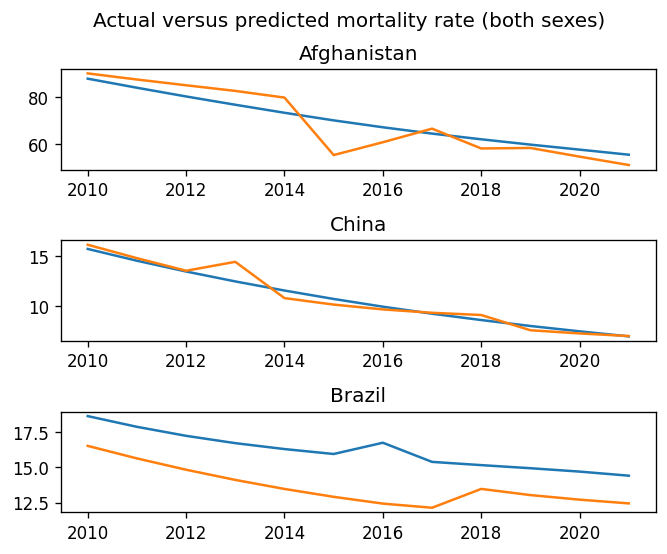

In [96]:
import matplotlib.pyplot as plt

countries_to_plot = ['Afghanistan', 'China', 'Brazil']
country_data_dict = {
    c: test_df[test_df['country'] == c][[
        'year',
        'mortality_rate_both_sexes',
        'mortality_rate_both_sexes_predicted',
    ]]
    for c in countries_to_plot
}
fig, axs = plt.subplots(len(countries_to_plot), )
fig.suptitle("Actual versus predicted mortality rate (both sexes)")
fig.set_dpi(120)
for i in range(0, len(countries_to_plot)):
    axs[i].set_title(countries_to_plot[i])
    axs[i].plot(
        country_data_dict[countries_to_plot[i]]['year'],
        country_data_dict[countries_to_plot[i]]['mortality_rate_both_sexes'],
    )
    axs[i].plot(
        country_data_dict[countries_to_plot[i]]['year'],
        country_data_dict[countries_to_plot[i]]['mortality_rate_both_sexes_predicted'],
    )

plt.subplots_adjust(hspace=0.7, wspace=10)
plt.show()


PermutationExplainer explainer: 2389it [1:15:13,  1.89s/it]                          


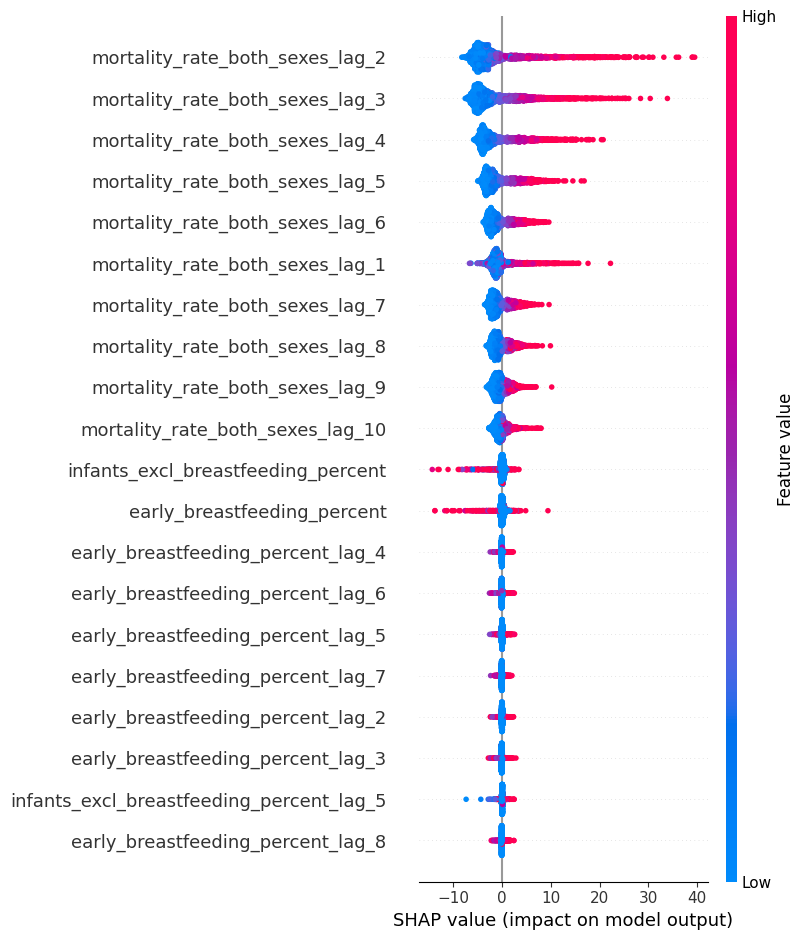

In [99]:
import shap
from shap.maskers import Independent
masker = Independent(X_test)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)